<a href="https://colab.research.google.com/github/AanchalA/MakeMore-with-Andrej-Karpathy/blob/main/MakeMoreNames_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F

import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# HyperParameters

In [ ]:
# HyperParameters

EPOCHS = 200000
BLOCK_SIZE = 8              ## Context Length: how many characters do we take to predict the next one?
BATCH_SIZE = 32
FUSION_SIZE = 2
LEARNING_RATE = 0.1
EMBEDDINGS_DIM = 24             ## Dimensionality of the Character Embedding Vectors
NUM_HIDDEN_UNITS = 128          ## Number of Neurons in the Hidden Layer of the MLP
LEARNING_RATE_DECAY = 0.01

# g = torch.Generator().manual_seed(2147483647)                   # for reproducibility
torch.manual_seed(42);          ## seed rng for reproducibility

# Building the DataSet

In [ ]:
! wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-06-04 16:10:32--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-06-04 16:10:32 (11.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt').read().splitlines()
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
# stoi['<S>'] = 26
# stoi['<E>'] = 27
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(f'{vocab_size}')

27


In [ ]:
def build_dataset(words):

    X, Y = list(), list()

    for w in words:

        # print(f"\nNAME: {w}")
        context = [0] * BLOCK_SIZE      ## [0, 0, 0]
        for ch in w + '.':              ## Appending '.' at the end of the name
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print('\t', ''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix]            ## POP from the top and then append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y

In [ ]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])                # 80%
Xdev, Ydev = build_dataset(words[n1:n2])            # 10%
Xte, Yte = build_dataset(words[n2:])                # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
num_examples = 20
for x, y in zip(Xtr[:num_examples], Ytr[:num_examples]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


# Model Preparation

In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) #/ fan_in ** 0.5           ## Default Kaiming Initilization: (sqrt(fan_in)) - Even pytorch uses this as the default init.
        self.bias = torch.zeros(fan_out) if bias else None


    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out


    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters (Trained with Back-Prop)
        self.gamma = torch.ones(dim)               ## Batch Normalization Gain (Scaling Parameter)
        self.beta = torch.zeros(dim)               ## Batch Normalization Bias (Shifting Parameter)

        # Buffers (Trained with a "Running Momentum Update" or "Exponential Moving Average")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        # Calculate the Forward Pass
        if self.training:

            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)

            xmean = x.mean(dim, keepdims=True)                ## Batch Mean
            xvar = x.var(dim, keepdims=True)                  ## Batch Variance

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)            ## Adding eps to xvar to avoide division by zero situation
        self.out = self.gamma * xhat + self.beta

        # Updating the Buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out


    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out


    def parameters(self):
        return []

In [ ]:
class Embedding:                ## Embedding layer embeddings are updated using Self-Attention in transformers

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))


    def __call__(self, IX):                     ## IX - List of Batch Indexes
        self.out = self.weight[IX]
        return self.out


    def parameters(self):
        return [self.weight]

In [ ]:
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out


    def parameters(self):
        return []

In [ ]:
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n                                      ## n - Fusion Size


    def __call__(self, x):
        B, T, C = x.shape                               ## B - Batch Size, T - Context Size, C - Embedding Dimension
        x = x.view(B, T // self.n, C * self.n)          ## T // self.n - Integer Division. This creates a batch dimension for the characters

        if x.shape[1] == 1:                             ## When T is odd, there will be one character left at the end without amy pair match
            x = x.squeeze(dim=1)                            ## torch.squeeze() - Squeezes "out" all the dimensions in a tensor that are 1. Here we are squeezing out dim=1 only, ie the single character dimension. So if T=1 x.squeeze will return (B, T, C) ===> as (B, C)
        self.out = x
        return x


    def parameters(self):
        return []

In [ ]:
class Sequential:

    def __init__(self, layers):
        self.layers = layers


    def __call__(self, x):                  ## X - Input/Batch Input
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out


    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

# Model Architecture


In [ ]:
# flat concatenation for Character Embeddings

# model = Sequential([
#     Embedding(vocab_size, EMBEDDINGS_DIM),

#     Flatten(),
#     Linear(fan_in=EMBEDDINGS_DIM * BLOCK_SIZE,
#            fan_out=NUM_HIDDEN_UNITS,
#            bias=False),
#     BatchNorm1D(dim=NUM_HIDDEN_UNITS),
#     Tanh(),

#     Linear(fan_in=NUM_HIDDEN_UNITS,
#            fan_out=vocab_size)
# ])

In [ ]:
# Character Embeddings are concatenated hierarchically (2 embedding vectors as a time) rather than a flat concatenation
# 1
# 1 1
# 1 1 1 1


model = Sequential([
    Embedding(vocab_size, EMBEDDINGS_DIM),

    FlattenConsecutive(FUSION_SIZE),
    Linear(fan_in=EMBEDDINGS_DIM * FUSION_SIZE,
           fan_out=NUM_HIDDEN_UNITS,
           bias=False),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),

    FlattenConsecutive(FUSION_SIZE),
    Linear(fan_in=NUM_HIDDEN_UNITS * FUSION_SIZE,
           fan_out=NUM_HIDDEN_UNITS,
           bias=False),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),

    FlattenConsecutive(FUSION_SIZE),
    Linear(fan_in=NUM_HIDDEN_UNITS * FUSION_SIZE,
           fan_out=NUM_HIDDEN_UNITS,
           bias=False),
    BatchNorm1D(dim=NUM_HIDDEN_UNITS),
    Tanh(),

    Linear(fan_in=NUM_HIDDEN_UNITS,
           fan_out=vocab_size)
])

In [ ]:
model

In [ ]:
## Weight Parameter Initilization for Last Layer
with torch.no_grad():
    # Last Layer: Make Less Confident (Fix for Softmax Confidently Wrong)
    model.layers[-1].weight *= 0.1

parameters = model.parameters()

for p in parameters:
    p.requires_grad = True

print(f"Total Number of Parameters: {sum(p.nelement() for p in parameters)}")

Total Number of Parameters: 76579


# Play-Ground

In [ ]:
# ix = torch.randint(0, Xtr.shape[0], (4, ))        ## Taking a batch of 4 examples
# Xb, Yb = Xtr[ix], Ytr[ix]
# logits = model(Xb)

# print(Xb.shape)
# Xb

In [ ]:
# for layer in model.layers:
#     print(layer.__class__.__name__, ":\t\t", tuple(layer.out.shape))

In [ ]:
# Embedding Layer Input: (4, 8)
model.layers[0].out.shape               ## Output of the Embedding Layer (0th layer)

torch.Size([1, 8, 24])

In [ ]:
model.layers[1].out.shape               ## Output of the Flatten Layer (1st layer)

In [ ]:
# # Inside the Linear Layer - Matrix multiplication only works on the last layer, all the other layers remain unchanged.
# h = torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)            ## h = X @ W + b

# # Which is why the shape of input matrix X does not matter.
# # All the dimensions in the middle are treated as batch dimensions.
# h = torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)            ## h = X @ W + b, Adding a batch dimension for the characters (dividing the characters into the given batch size)
# # Example
# # [1, 2, 3, 4, 5, 6, 7, 8]  ---> [(1, 2), (3, 4), (5, 6), (7, 8)]

# print(h.shape)
# model.layers[2].out.shape               ## Output of the Linear Layer (2nd Layer)

In [ ]:
# e = torch.randn(4, 8, 10)       ## GOAL: Want this to be a (4, 4, 20) where consecutive 10-d vectors get concatenated.
# e.view(4, -1).shape             ## Current Implementation

In [ ]:
# # Get even indexes from list
# list(range(10))[::2]            ## Start with row_index=0 step=2

In [ ]:
# # Get odd indexes from list
# list(range(10))[1::2]           ## Start with row_index=1 step=2

In [ ]:
# # e[:, ::2, :] - Taking dim=0 as it is, taking only even index from dim=1, taking dim=2 as it is from all the indexes selected in dim=1 and concatenating them.
# torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape

In [ ]:
# e.view(4, 4, 20).shape

In [ ]:
# e = torch.randn(32, 4, 68)                                  ## Input for BatchNorm1D Layer
# emean = e.mean(0, keepdim=True)                             ## Resultant dimensions: (1, 4, 68). Taking mean over the 32 inputs in dim=0
# print(emean.shape)
# evar = e.var(0, keepdim=True)                               ## Resultant dimensions: (1, 4, 68). Taking var over the 32 inputs in dim=0
# print(evar.shape)
# ehat = (e - emean) / torch.sqrt(evar + 1e-5)                ## Resultant dimensions: (32, 4, 68). Dimensions get reset because of broadcasting.
# print(ehat.shape)

In [ ]:
model.layers[3].running_mean.shape

torch.Size([128])

In [ ]:
# e = torch.randn(32, 4, 68)                                      ## Input for BatchNorm1D Layer. We want to take the mean, var over (32 * 4) rather than just (32)
# emean = e.mean((0, 1), keepdim=True)                            ## Resultant dimensions: (1, 4, 68). Taking mean over the 32 inputs in dim=0
# print(emean.shape)
# evar = e.var((0, 1), keepdim=True)                              ## Resultant dimensions: (1, 4, 68). Taking var over the 32 inputs in dim=0
# print(evar.shape)
# ehat = (e - emean) / torch.sqrt(evar + 1e-5)                    ## Resultant dimensions: (32, 4, 68). Dimensions get reset because of broadcasting.
# print(ehat.shape)

# Model Training

In [ ]:
loss_i = list()
update_to_data_ratio = list()

for i in range(EPOCHS):

    ## Mini Batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ))
    Xb, Yb = Xtr[ix], Ytr[ix]           ## Batch X, Y


    ## Forward Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)       ## Loss Function


    ## Backward Pass
    # for layer in model.layers:
    #     layer.out.retain_grad()         ## AFTER_DEBUG: Would comment out retain_grad

    for p in parameters:
        p.grad = None                   ## Resetting the gradients

    loss.backward()


    ## Parameter Update
    lr = LEARNING_RATE if i < EPOCHS / 2 else LEARNING_RATE_DECAY
    for p in parameters:
        p.data += -lr * p.grad


    ## Track Stats
    if i % 10000 == 0:
        print(f"{i:7d}/{EPOCHS:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        update_to_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


    # break

      0/ 200000: 3.7328
  10000/ 200000: 2.2183
  20000/ 200000: 2.3063
  30000/ 200000: 2.6285
  40000/ 200000: 2.2761
  50000/ 200000: 1.8845
  60000/ 200000: 2.3088
  70000/ 200000: 2.0507
  80000/ 200000: 1.9589
  90000/ 200000: 2.1656
 100000/ 200000: 1.9706
 110000/ 200000: 2.2438
 120000/ 200000: 1.8237
 130000/ 200000: 2.1603
 140000/ 200000: 1.7578
 150000/ 200000: 1.8815
 160000/ 200000: 2.0696
 170000/ 200000: 1.9531
 180000/ 200000: 1.8138
 190000/ 200000: 2.1551


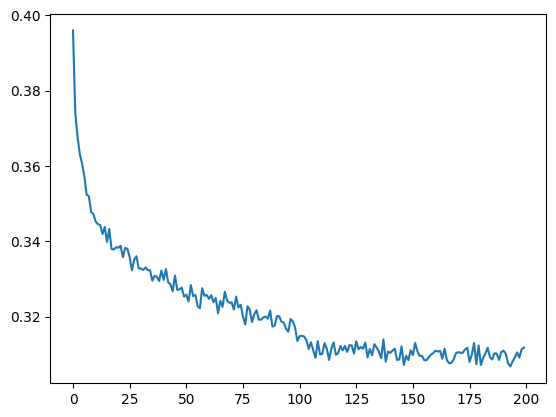

In [ ]:
# plt.plot(loss_i)
plt.plot(torch.tensor(loss_i).view(-1, 1000).mean(1))

# Evaluate Loss on Train and Test Set

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):

  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [ ]:
split_loss('train')
split_loss('val')

train 2.0172271728515625
val 2.07413911819458


# Inference

In [ ]:
## sample from the model
# g = torch.Generator().manual_seed(2147483647 + 10)

num_examples = 20
for _ in range(num_examples):

    out = list()
    context = [0] * BLOCK_SIZE # initialize with all ...

    while True:
        ## forward pass the neural net
        logits = model(torch.tensor([context])) # (1,block_size,n_embd)
        probs = F.softmax(logits, dim=1)

        ## sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        ## shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        ## if we sample the special '.' token, break
        if ix == 0:
          break

    ## decode and print the generated word
    print(''.join(itos[i] for i in out))

aiyanah.
giusop.
jener.
shria.
raylie.
francata.
kaylen.
mccencne.
apsond.
laylynn.
xavan.
jaice.
myudar.
dacphrin.
jakir.
isabiah.
jaissah.
layaie.
mancari.
yeniel.


# Why Use Convolutions - Brief Preview / Hint

In [ ]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

In [ ]:
# forward a single example

logits = model(Xtr[[7]])
logits.shape

In [ ]:
# forward all of them

logits = torch.zeros(8, 27)

for i in range(8):
  logits[i] = model(Xtr[[7+i]])

logits.shape

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space